<a href="https://colab.research.google.com/github/fairyex/cyberpunk_pic_generate/blob/main/cyberpunk_anime_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyberpunk-Anime-Diffusion

by [DGSpitzer](https://www.youtube.com/channel/UCzzsYBF4qwtMwJaPJZ5SuPg)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelixNGC7293/cyberpunk-anime-diffusion/blob/main/cyberpunk_anime_diffusion.ipynb) [![GitHub](https://badgen.net/badge/icon/Github?icon=github&label)](https://github.com/HelixNGC7293/cyberpunk-anime-diffusion) [![Buy me a coffee](https://badgen.net/badge/icon/Buy%20Me%20A%20Coffee?icon=buymeacoffee&label)](https://www.buymeacoffee.com/dgspitzer)

---

This is a simple notebook to demonstrate the usage of cyberpunk-anime-diffusion.

***NOTE:*** Almost all of this notebook's code is lifted from [nousr](https://mobile.twitter.com/nousr_) and [Deforum](https://github.com/deforum/stable-diffusion) colab notebook. Big shout out to them o(*￣▽￣*)ブ

# Setup 

In [6]:
#@markdown **Model and Output Paths**
# ask for the link
print("Local Path Variables:\n")

models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Local Path Variables:

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [2]:
#@markdown **Setup Environment**

setup_environment = True #@param {type:"boolean"}
print_subprocess = False #@param {type:"boolean"}

if setup_environment:
    import subprocess, time
    print("Setting up environment...")
    start_time = time.time()
    all_process = [
        ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
        ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
        ['git', 'clone', 'https://github.com/deforum/stable-diffusion'],
        ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
        ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
        ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq'],
        ['git', 'clone', 'https://github.com/shariqfarooq123/AdaBins.git'],
        ['git', 'clone', 'https://github.com/isl-org/MiDaS.git'],
        ['git', 'clone', 'https://github.com/MSFTserver/pytorch3d-lite.git'],
    ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)
    
    print(subprocess.run(['git', 'clone', 'https://github.com/deforum/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
        f.write('')

    end_time = time.time()
    print(f"Environment set up in {end_time-start_time:.0f} seconds")

Setting up environment...

Environment set up in 72 seconds


In [3]:
"""
https://github.com/deforum/stable-diffusion
"""

#@markdown **Python Definitions**
import json
from IPython import display

import gc, math, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast

sys.path.extend([
    'src/taming-transformers',
    'src/clip',
    'stable-diffusion/',
    'k-diffusion',
    'pytorch3d-lite',
    'AdaBins',
    'MiDaS',
])

from helpers import DepthModel, sampler_fn
from k_diffusion.external import CompVisDenoiser
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def sanitize(prompt):
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    tmp = ''.join(filter(whitelist.__contains__, prompt))
    return tmp.replace(' ', '_')

def anim_frame_warp_2d(prev_img_cv2, args, anim_args, keys, frame_idx):
    angle = keys.angle_series[frame_idx]
    zoom = keys.zoom_series[frame_idx]
    translation_x = keys.translation_x_series[frame_idx]
    translation_y = keys.translation_y_series[frame_idx]

    center = (args.W // 2, args.H // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    xform = np.matmul(rot_mat, trans_mat)

    return cv2.warpPerspective(
        prev_img_cv2,
        xform,
        (prev_img_cv2.shape[1], prev_img_cv2.shape[0]),
        borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
    )

def add_noise(sample: torch.Tensor, noise_amt: float) -> torch.Tensor:
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape, use_alpha_as_mask=False):
    # use_alpha_as_mask: Read the alpha channel of the image as the mask image
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    if use_alpha_as_mask:
        image = image.convert('RGBA')
    else:
        image = image.convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)

    mask_image = None
    if use_alpha_as_mask:
      # Split alpha channel into a mask_image
      red, green, blue, alpha = Image.Image.split(image)
      mask_image = alpha.convert('L')
      image = image.convert('RGB')

    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    image = 2.*image - 1.

    return image, mask_image

def load_mask_latent(mask_input, shape):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    
    if isinstance(mask_input, str): # mask input is probably a file name
        if mask_input.startswith('http://') or mask_input.startswith('https://'):
            mask_image = Image.open(requests.get(mask_input, stream=True).raw).convert('RGBA')
        else:
            mask_image = Image.open(mask_input).convert('RGBA')
    elif isinstance(mask_input, Image.Image):
        mask_image = mask_input
    else:
        raise Exception("mask_input must be a PIL image or a file name")

    mask_w_h = (shape[-1], shape[-2])
    mask = mask_image.resize(mask_w_h, resample=Image.LANCZOS)
    mask = mask.convert("L")
    return mask

def prepare_mask(mask_input, mask_shape, mask_brightness_adjust=1.0, mask_contrast_adjust=1.0):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    # mask_brightness_adjust (non-negative float): amount to adjust brightness of the iamge, 
    #     0 is black, 1 is no adjustment, >1 is brighter
    # mask_contrast_adjust (non-negative float): amount to adjust contrast of the image, 
    #     0 is a flat grey image, 1 is no adjustment, >1 is more contrast
    
    mask = load_mask_latent(mask_input, mask_shape)

    # Mask brightness/contrast adjustments
    if mask_brightness_adjust != 1:
        mask = TF.adjust_brightness(mask, mask_brightness_adjust)
    if mask_contrast_adjust != 1:
        mask = TF.adjust_contrast(mask, mask_contrast_adjust)

    # Mask image to array
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = np.expand_dims(mask,axis=0)
    mask = torch.from_numpy(mask)

    if args.invert_mask:
        mask = ( (mask - 0.5) * -1) + 0.5
    
    mask = np.clip(mask,0,1)
    return mask

def maintain_colors(prev_img, color_match_sample, mode):
    if mode == 'Match Frame 0 RGB':
        return match_histograms(prev_img, color_match_sample, multichannel=True)
    elif mode == 'Match Frame 0 HSV':
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else: # Match Frame 0 LAB
        prev_img_lab = cv2.cvtColor(prev_img, cv2.COLOR_RGB2LAB)
        color_match_lab = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2LAB)
        matched_lab = match_histograms(prev_img_lab, color_match_lab, multichannel=True)
        return cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)


def make_callback(sampler_name, dynamic_threshold=None, static_threshold=None, mask=None, init_latent=None, sigmas=None, sampler=None, masked_noise_modifier=1.0):  
    # Creates the callback function to be passed into the samplers
    # The callback function is applied to the image at each step
    def dynamic_thresholding_(img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback_(args_dict):
        if dynamic_threshold is not None:
            dynamic_thresholding_(args_dict['x'], dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*static_threshold, static_threshold)
        if mask is not None:
            init_noise = init_latent + noise * args_dict['sigma']
            is_masked = torch.logical_and(mask >= mask_schedule[args_dict['i']], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + args_dict['x'] * torch.where(is_masked,0,1)
            args_dict['x'].copy_(new_img)

    # Function that is called on the image (img) and step (i) at each step
    def img_callback_(img, i):
        # Thresholding functions
        if dynamic_threshold is not None:
            dynamic_thresholding_(img, dynamic_threshold)
        if static_threshold is not None:
            torch.clamp_(img, -1*static_threshold, static_threshold)
        if mask is not None:
            i_inv = len(sigmas) - i - 1
            init_noise = sampler.stochastic_encode(init_latent, torch.tensor([i_inv]*batch_size).to(device), noise=noise)
            is_masked = torch.logical_and(mask >= mask_schedule[i], mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + img * torch.where(is_masked,0,1)
            img.copy_(new_img)
              
    if init_latent is not None:
        noise = torch.randn_like(init_latent, device=device) * masked_noise_modifier
    if sigmas is not None and len(sigmas) > 0:
        mask_schedule, _ = torch.sort(sigmas/torch.max(sigmas))
    elif len(sigmas) == 0:
        mask = None # no mask needed if no steps (usually happens because strength==1.0)
    if sampler_name in ["plms","ddim"]: 
        # Callback function formated for compvis latent diffusion samplers
        if mask is not None:
            assert sampler is not None, "Callback function for stable-diffusion samplers requires sampler variable"
            batch_size = init_latent.shape[0]

        callback = img_callback_
    else: 
        # Default callback function uses k-diffusion sampler variables
        callback = k_callback_

    return callback

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor, type=np.uint8) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255)
    return sample_int8.astype(type)

def generate(args, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    sampler = PLMSSampler(model) if args.sampler == 'plms' else DDIMSampler(model)
    model_wrap = CompVisDenoiser(model)
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    precision_scope = autocast if args.precision == "autocast" else nullcontext

    init_latent = None
    mask_image = None
    init_image = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.use_init and args.init_image != None and args.init_image != '':
        init_image, mask_image = load_img(args.init_image, 
                                          shape=(args.W, args.H),  
                                          use_alpha_as_mask=args.use_alpha_as_mask)
        init_image = init_image.to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    if not args.use_init and args.strength > 0 and args.strength_0_no_init:
        print("\nNo init image, but strength > 0. Strength has been auto set to 0, since use_init is False.")
        print("If you want to force strength > 0 with no init, please set strength_0_no_init to False.\n")
        args.strength = 0

    # Mask functions
    if args.use_mask:
        assert args.mask_file is not None or mask_image is not None, "use_mask==True: An mask image is required for a mask. Please enter a mask_file or use an init image with an alpha channel"
        assert args.use_init, "use_mask==True: use_init is required for a mask"
        assert init_latent is not None, "use_mask==True: An latent init image is required for a mask"

        mask = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                            init_latent.shape, 
                            args.mask_contrast_adjust, 
                            args.mask_brightness_adjust)
        
        if (torch.all(mask == 0) or torch.all(mask == 1)) and args.use_alpha_as_mask:
            raise Warning("use_alpha_as_mask==True: Using the alpha channel from the init image as a mask, but the alpha channel is blank.")
        
        mask = mask.to(device)
        mask = repeat(mask, '1 ... -> b ...', b=batch_size)
    else:
        mask = None
        
    t_enc = int((1.0-args.strength) * args.steps)

    # Noise schedule for the k-diffusion samplers (used for masking)
    k_sigmas = model_wrap.get_sigmas(args.steps)
    k_sigmas = k_sigmas[len(k_sigmas)-t_enc-1:]

    if args.sampler in ['plms','ddim']:
        sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, ddim_discretize='fill', verbose=False)

    callback = make_callback(sampler_name=args.sampler,
                            dynamic_threshold=args.dynamic_threshold, 
                            static_threshold=args.static_threshold,
                            mask=mask, 
                            init_latent=init_latent,
                            sigmas=k_sigmas,
                            sampler=sampler)    

    results = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    uc = None
                    if args.scale != 1.0:
                        uc = model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model.get_learned_conditioning(prompts)

                    if args.init_c != None:
                        c = args.init_c

                    if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                        samples = sampler_fn(
                            c=c, 
                            uc=uc, 
                            args=args, 
                            model_wrap=model_wrap, 
                            init_latent=init_latent, 
                            t_enc=t_enc, 
                            device=device, 
                            cb=callback)
                    else:
                        # args.sampler == 'plms' or args.sampler == 'ddim':
                        if init_latent is not None and args.strength > 0:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        else:
                            z_enc = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)
                        if args.sampler == 'ddim':
                            samples = sampler.decode(z_enc, 
                                                     c, 
                                                     t_enc, 
                                                     unconditional_guidance_scale=args.scale,
                                                     unconditional_conditioning=uc,
                                                     img_callback=callback)
                        elif args.sampler == 'plms': # no "decode" function in plms, so use "sample"
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            samples, _ = sampler.sample(S=args.steps,
                                                            conditioning=c,
                                                            batch_size=args.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=args.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=args.ddim_eta,
                                                            x_T=z_enc,
                                                            img_callback=callback)
                        else:
                            raise Exception(f"Sampler {args.sampler} not recognised.")

                    if return_latent:
                        results.append(samples.clone())

                    x_samples = model.decode_first_stage(samples)
                    if return_sample:
                        results.append(x_samples.clone())

                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    if return_c:
                        results.append(c.clone())

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image = Image.fromarray(x_sample.astype(np.uint8))
                        results.append(image)
    return results

In [5]:
#@markdown **Download Model**

model_config = "v1-inference.yaml"
model_checkpoint =  "Cyberpunk-Anime-Diffusion.ckpt"

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True #@param {type: 'boolean'}
check_sha256 = False #@param {type:"boolean"}

model_map = {
    "Cyberpunk-Anime-Diffusion.ckpt": {
        'sha256': 'a8f7dcece7bc4a6273ed1efa427d481b03237a8f635f1bc44128dd48217a2947',
        'url': 'https://huggingface.co/DGSpitzer/Cyberpunk-Anime-Diffusion/resolve/main/Cyberpunk-Anime-Diffusion.ckpt',
        'requires_login': False,
        },
}

# config path
ckpt_config_path = os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    ckpt_config_path = "./stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
print(f"Using config: {ckpt_config_path}")

# checkpoint path or download
ckpt_path = os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    print(f"{ckpt_path} exists")
elif 'url' in model_map[model_checkpoint]:
    url = model_map[model_checkpoint]['url']

    print(f"Attempting to download {model_checkpoint}")

    ckpt_request = requests.get(url)

    request_status = ckpt_request.status_code
    
    if request_status == 403:
      raise ConnectionRefusedError("You have not accepted the license for this model.")
    elif request_status == 404:
      raise ConnectionError("Could not make contact with server")
    elif request_status != 200:
      raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

    with open(os.path.join(models_path, model_checkpoint), 'wb') as model_file:
        model_file.write(ckpt_request.content)
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("\n...checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")
        ckpt_valid = False

if ckpt_valid:
    print(f"Using ckpt: {ckpt_path}")

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if load_on_run_all and ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

Using config: ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml
Attempting to download Cyberpunk-Anime-Diffusion.ckpt
Using ckpt: /content/models/Cyberpunk-Anime-Diffusion.ckpt
Loading model from /content/models/Cyberpunk-Anime-Diffusion.ckpt
Global Step: 13700
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.mlp.fc1.weight', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.encoder.layers.14.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.layer_

# Create

In [15]:
# ================================================================================================ #
# NOTE: for cyberpunk-anime-diffusion to work you must have the key word 'dgs', with 'illustration style' to get even better results #
# ================================================================================================ #
# Example: 'A photo of a dgs girl'                                                                 #
# Example: 'Portrait of a girl in dgs illustration style'                                          #
# ================================================================================================ #

prompts = [
    "portrait of a male wolf in dgs illustration style, Anime male wolf, male wolf soldier working in a cyberpunk city, cleavage, ((perfect femine face)), intricate, 8k, highly detailed, digital painting, intense, sharp focus",
]

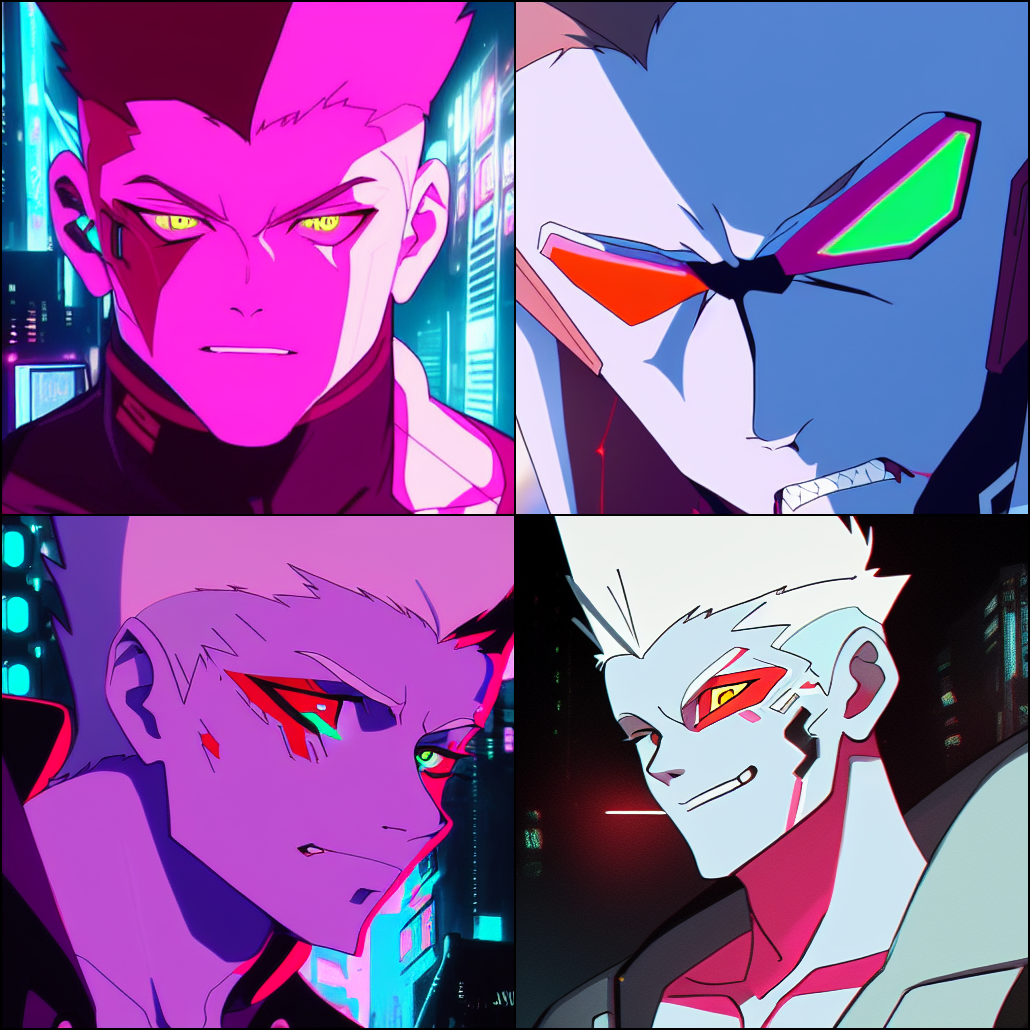

In [17]:
def DeforumArgs():

    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 27 #@param
    scale = 7.5 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 4 #@param
    batch_name = "cyberpunk-anime-diffusion" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = True #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://pbs.twimg.com/profile_images/1567590367545159681/jHqrXuv7_400x400.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()



def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32 - 1)
    return args.seed

def render_image_batch(args):
    args.prompts = {k: f"{v:05d}" for v, k in enumerate(prompts)}
    
    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0
    
    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/" 
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""]

    # when doing large batches don't flood browser with images
    clear_between_batches = args.n_batch >= 32

    for iprompt, prompt in enumerate(prompts):  
        args.prompt = prompt
        print(f"Prompt {iprompt+1} of {len(prompts)}")
        print(f"{args.prompt}")

        all_images = []

        for batch_index in range(args.n_batch):
            if clear_between_batches and batch_index % 32 == 0: 
                display.clear_output(wait=True)            
            print(f"Batch {batch_index+1} of {args.n_batch}")
            
            for image in init_array: # iterates the init images
                args.init_image = image
                results = generate(args)
                for image in results:
                    if args.make_grid:
                        all_images.append(T.functional.pil_to_tensor(image))
                    if args.save_samples:
                        if args.filename_format == "{timestring}_{index}_{prompt}.png":
                            filename = f"{args.timestring}_{index:05}_{sanitize(prompt)[:160]}.png"
                        else:
                            filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)

        #print(len(all_images))
        if args.make_grid:
            grid = make_grid(all_images, nrow=int(len(all_images)/args.grid_rows))
            grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()
            filename = f"{args.timestring}_{iprompt:05d}_grid_{args.seed}.png"
            grid_image = Image.fromarray(grid.astype(np.uint8))
            grid_image.save(os.path.join(args.outdir, filename))
            display.clear_output(wait=True)            
            display.display(grid_image)

args = SimpleNamespace(**DeforumArgs())

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and args.use_init:
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
render_image_batch(args)    